# Implementación de Siamese Network

## ¿Que es una Siamese Network?

Es un tipo especial de arquitecura de red neuronal que permite comparar dos imagenes y determinar si son similares o no, la caracteristica principal de este tipo de red es que comparten los mismos pesos y arquitectura, es decir, son dos redes neuronales que comparten los mismos pesos y arquitectura, esto permite que la red pueda aprender a comparar dos imagenes y determinar si son similares o no.

## Importar modulos

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

## Preparar los datos

In [35]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# cast to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('fashion_mnist train shape:', X_train.shape)
print('fashion_mnist test shape:', X_test.shape)

# normalize data
X_train /= 255.
X_test /= 255.

fashion_mnist train shape: (60000, 28, 28)
fashion_mnist test shape: (10000, 28, 28)


## Crear nuestros pares de datos positivos y negativos

- **Pares positivos**: Dos imágenes que contienen las mismas caracteristicas
- **Pares negativos**: Dos imágenes que contienen diferentes caracteristicas

In [36]:
def create_pairs(X: np.ndarray, y: np.ndarray):
    """
    Args:
        X (np.ndarray): Array de imagenes
        y (np.ndarray): Array de etiquetas
    return:
        pairs (np.ndarray): Array de pares de imagenes
        labels: Etiquetas de las imagenes, 1 si son pares positivos y 0 si son pares negativos
    """
    
    # image indices by class labels: y
    num_classes = max(y) + 1
    indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    pairs, labels = [], []
    
    # max number of pairs using the min number of images by class
    n = min([len(i) for i in indices]) - 1
    
    for c in range(num_classes):
        for i in range(n):
            # positive pair
            img1 = X[indices[c][i]]
            # next image of the same class
            img2 = X[indices[c][i+1]]
            pairs.append((img1, img2))
            labels.append(1.)
            
            # negative pair
            # select a random class
            neg = np.random.choice([_c for _c in range(num_classes) if _c != c])
            # select a random image
            img1 = X[indices[c][i]]
            img2 = X[indices[neg][i]]
            pairs.append((img1, img2))
            labels.append(0.)
            
    return np.array(pairs), np.array(labels)
 

In [37]:
X_train_pair, y_train_bin = create_pairs(X_train, y_train)
X_test_pair, y_test_bin = create_pairs(X_test, y_test)
print(f'train pair: {X_train_pair.shape} and type {X_train_pair.dtype} label: {y_train_bin.shape} type {y_train_bin.dtype}')
print(f'test pair: {X_test_pair.shape} and type {X_test_pair.dtype} labe: {y_test_bin.shape} type {y_test_bin.dtype}')

train pair: (119980, 2, 28, 28) and type float32 label: (119980,) type float64
test pair: (19980, 2, 28, 28) and type float32 labe: (19980,) type float64


Ya preparamos los pares de datos para entrenar la red neuronal ahora por cada ejemplo en nuestra input tenemos dos images y nuestro output es un valor 0 o 1 dependiendo si son negativos o positivos respectivamente.

Para poder tener un contexto visual graficaremos las imagenes de ejemplo, una a lado de la otra. En el código usamos un random para seleccionar el par de imagenes a mostrar esto se hace para que se pueda jugar por los datos y ver distintos ejemplos.

In [38]:
def plot_pair(pair: np.ndarray, label: float, pred: float = None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(pair[0])
    ax[1].imshow(pair[1])
    if label:
        title = "Positivo"
    else:
        title = "Negativo"
        
    if pred is not None:
        if pred < 0.5:
            title += f" - pred: {pred:.2f} - Positivo"
        else:
            title += f" - pred: {pred:.2f} - Negativo"
    fig.suptitle(title)
    plt.show()

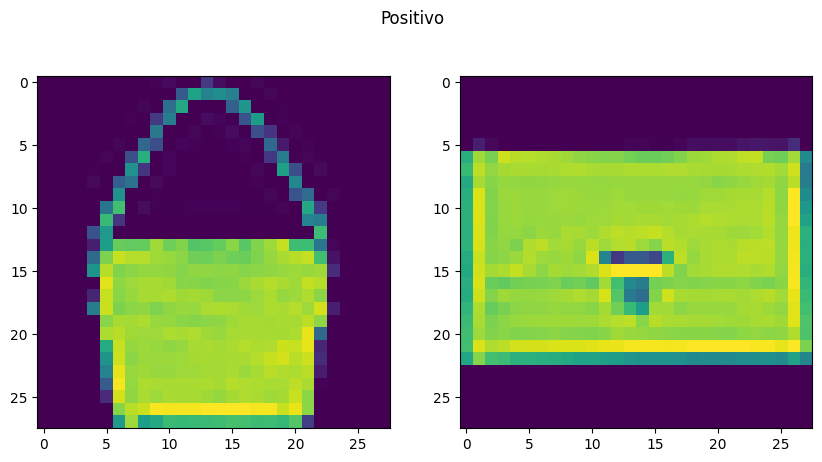

In [39]:
num_exam = random.randrange(len(X_train_pair))
plot_pair(X_train_pair[num_exam], y_train_bin[num_exam])

## Modelo base

In [40]:
input_shape = (28, 28, )
def build_model_base():
    input = tf.keras.Input(shape=input_shape, name="base_input")
    x = tf.keras.layers.Flatten(name="flatten_input")(input)
    x = tf.keras.layers.Dense(128, activation='relu', name="first_base_dense")(x)
    x = tf.keras.layers.Dropout(0.1, name="first_dropout")(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="second_base_dense")(x)
    x = tf.keras.layers.Dropout(0.1, name="second_dropout")(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="third_base_dense")(x)
    
    return tf.keras.Model(inputs=input, outputs=x, name="base_model")

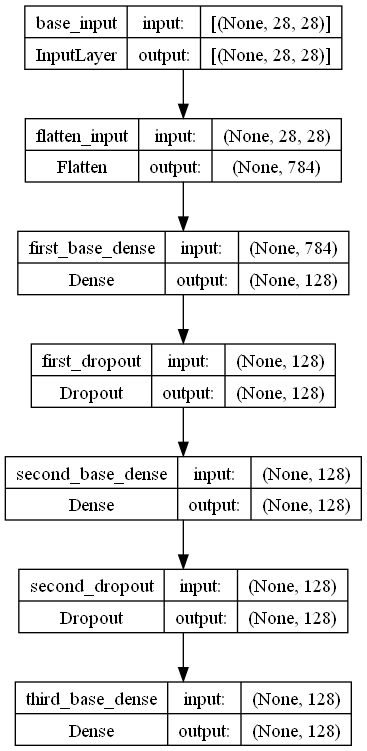

In [41]:
model_base = build_model_base()
tf.keras.utils.plot_model(model_base, show_shapes=True)

Vamos ahora a construir la Siamense Network, donde podremos ver que tenemos dos entradas que se enviaran a al modelo base y esta pasara por una capa personalizada que calculara la distancia entre los dos vectores de salida de la red base, distancia euclidiana

### Distancia Euclidiana

la distancia euclidiana es una medida de distancia entre dos puntos que se puede generalizar a cualquier dimensión. En otras palabras, es la distancia entre dos puntos que se puede medir con una regla. En dos dimensiones, la distancia euclidiana entre los puntos


In [42]:
def euclidean_distance(vects):
    import keras.backend as K
    vect_a, vect_b = vects
    sum_square = K.sum(K.square(vect_a - vect_b), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def ouput_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

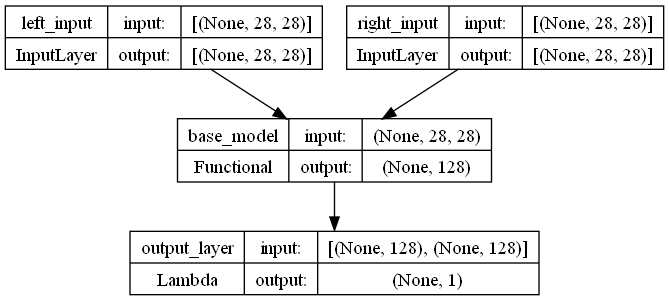

In [43]:
# create input a
input_a = tf.keras.Input(shape=input_shape, name='left_input')
vect_output_a = model_base(input_a)

# create input b
input_b = tf.keras.Input(shape=input_shape, name='right_input')
vect_output_b = model_base(input_b)

# measure the similarity of the two vectorized outputs
output  = tf.keras.layers.Lambda(euclidean_distance, name='output_layer', output_shape=ouput_shape)([vect_output_a, vect_output_b])

# create the model
model = tf.keras.Model([input_a, input_b], output)
tf.keras.utils.plot_model(model, show_shapes=True)

## Configurar modelo

In [44]:

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        import tensorflow.keras.backend as K
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [45]:
rms = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=rms, loss=contrastive_loss_with_margin(1), metrics=['accuracy'])

## Entrenamos el modelo

In [46]:
history = model.fit([X_train_pair[:, 0], X_train_pair[:, 1]], y_train_bin, epochs=30, batch_size=180, validation_data=([X_test_pair[:, 0], X_test_pair[:, 1]], y_test_bin))

Epoch 1/30
667/667 [==============================] - 5s 6ms/step - loss: 0.1791 - accuracy: 0.2385 - val_loss: 0.1182 - val_accuracy: 0.1557
Epoch 2/30
667/667 [==============================] - 4s 6ms/step - loss: 0.1184 - accuracy: 0.1506 - val_loss: 0.1027 - val_accuracy: 0.1378
Epoch 3/30
667/667 [==============================] - 5s 7ms/step - loss: 0.1055 - accuracy: 0.1330 - val_loss: 0.0954 - val_accuracy: 0.1259
Epoch 4/30
667/667 [==============================] - 4s 6ms/step - loss: 0.0977 - accuracy: 0.1214 - val_loss: 0.0912 - val_accuracy: 0.1204
Epoch 5/30
667/667 [==============================] - 5s 7ms/step - loss: 0.0921 - accuracy: 0.1134 - val_loss: 0.0873 - val_accuracy: 0.1146
Epoch 6/30
667/667 [==============================] - 4s 6ms/step - loss: 0.0883 - accuracy: 0.1082 - val_loss: 0.0841 - val_accuracy: 0.1092
Epoch 7/30
667/667 [==============================] - 5s 7ms/step - loss: 0.0848 - accuracy: 0.1036 - val_loss: 0.0817 - val_accuracy: 0.1066
Epoch 

## Evaluamos el modelo

In [ ]:
pred = model.predict([X_test_pair[:, 0], X_test_pair[:, 1]])

In [ ]:
examples = np.random.choice(range(len(pred)), size=5, replace=False)

for i in examples:
    plot_pair(X_test_pair[i], y_test_bin[i], pred[i][0])

## graficar funcion de perdida


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo de perdida')
plt.ylabel('Perdida')
plt.show()